## Links for Datasets

In [ ]:
# https://medium.com/@sudiplaudari/yolov10-a-step-by-step-guide-to-object-detection-on-a-custom-dataset-9f3e3e56921c -- yolo preprocessing article
# https://www.kaggle.com/datasets/vencerlanz09/taco-dataset-yolo-format -- taco dataset

## Installing Packages

In [ ]:
! pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 32.4 MB/s eta 0:00:00


In [ ]:
! pip install kaggle

Connecting to drive for efficient storage

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


## Dowload and Transfer dataset to google drive

In [ ]:
! kaggle datasets download vencerlanz09/taco-dataset-yolo-format

Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/taco-dataset-yolo-format
License(s): other
 96% 222M/232M [00:02<00:00, 98.6MB/s]
100% 232M/232M [00:02<00:00, 99.1MB/s]


In [ ]:
zip_file_path = '/content/taco-dataset-yolo-format.zip'  # Path to your zip file in Colab
destination_folder = '/content/drive/My Drive/Waste Detection and Classification/'  # Destination folder in Google Drive

# Create the destination folder if it doesn't exist
!mkdir -p "$destination_folder"

# Step 3: Unzip the file
!unzip -q "$zip_file_path" -d "$destination_folder"

print("Unzip completed successfully!")

Unzip completed successfully!


## Code for Dataset Training

Importing Packages

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='jshtml')
from PIL import Image

import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.5/107.7 GB disk)


Setting up and Training Model

In [ ]:
model = YOLO("yolov10x.pt")

NameError: name 'YOLO' is not defined

In [ ]:
!yolo task=detect mode=train model=yolov8x.pt data=data.yaml epochs=4 imgsz=512

Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=data.yaml, epochs=4, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=Non

#### Dataset Preprocessing

The dataset includes 6004 images.
Litter are annotated in YOLOv8 format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 416x416 (Stretch)

The following augmentation was applied to create 2 versions of each source image:
* 50% probability of horizontal flip
* 50% probability of vertical flip
* Equal probability of one of the following 90-degree rotations: none, clockwise, upside-down

In [ ]:
# Normalization and Scaling
from torchvision import transforms

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),            # Rescale image to 224x224 pixels
    transforms.ToTensor(),                    # Convert image to PyTorch tensor and scale pixel values to [0, 1]
    transforms.RandomResizedCrop((224, 224), scale=(0.9, 1.1)),
    transforms.RandomRotation(degrees=15)
])


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Create a dataset with transformations
dataset = ImageFolder(root='/content/drive/My Drive/Waste Detection and Classification/data.yaml', transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Normalization and Scaling
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),                 # Rescale image to 512x512 pixels
    transforms.RandomHorizontalFlip(p=0.5),       # 50% probability of horizontal flip
    transforms.RandomVerticalFlip(p=0.5),         # 50% probability of vertical flip
    transforms.RandomResizedCrop((224, 224), scale=(0.9, 1.1)),  # Randomly crop and resize
    transforms.RandomRotation(degrees=15),        # Random rotation within ±15 degrees
    transforms.ToTensor()                         # Convert image to PyTorch tensor
])

# Create a dataset with transformations
dataset = ImageFolder(root='/content/drive/My Drive/Waste Detection and Classification/data', transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example: Iterate through the DataLoader
for images, labels in dataloader:
    print(images.shape, labels.shape)

Training YOLO Model

In [ ]:
from ultralytics import YOLO

# Define path to your dataset.yaml file
dataset_yaml_path = '/content/drive/My Drive/Waste Detection and Classification/data.yaml'

#model = YOLO('yolov8n.yaml')
checkpoint_path = '/content/drive/My Drive/Waste Detection and Classification/exp/weights/best.pt'
file_path = '/content/drive/My Drive/Waste Detection and Classification/exp/'

# Train the model
model.train(
    data=dataset_yaml_path,    # Path to the dataset.yaml file
    imgsz=640,                 # Image size (e.g., 640x640)
    batch=16,                  # Batch size (adjust based on your GPU memory)
    epochs=50,                 # Number of training epochs
    #weights='yolov8n.pt',      # Pre-trained weights, e.g., 'yolov8n.pt' for nano model
    device='cuda',             # Device for training ('cuda' for GPU, 'cpu' for CPU)
    save=True,                 # Save the best model during training
    project='runs/train',      # Directory to save the training results
    name=file_path,                # Name of the experiment (folder under runs/train)
    save_period=3
)

# You can specify hyperparameters (optional)

Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/drive/My Drive/Waste Detection and Classification/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=3, cache=False, device=cuda, workers=8, project=runs/train, name=exp, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False,

train: Scanning /content/drive/My Drive/Waste Detection and Classification/train/labels... 4200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4200/4200 [28:03<00:00,  2.49it/s]


train: New cache created: /content/drive/My Drive/Waste Detection and Classification/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/My Drive/Waste Detection and Classification/valid/labels... 1704 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1704/1704 [12:19<00:00,  2.30it/s]


val: New cache created: /content/drive/My Drive/Waste Detection and Classification/valid/labels.cache
Plotting labels to /content/drive/My Drive/Waste Detection and Classification/exp/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000455, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/My Drive/Waste Detection and Classification/exp
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      13.5G      1.252      3.157      1.319         41        640: 100%|██████████| 263/263 [05:36<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:56<00:00,  1.05s/it]


                   all       1704       4830      0.262      0.192     0.0835      0.056

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      13.8G      1.376      2.751      1.432         22        640: 100%|██████████| 263/263 [05:35<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:54<00:00,  1.01s/it]


                   all       1704       4830      0.219      0.121     0.0565     0.0356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      13.5G       1.43      2.773      1.447         42        640: 100%|██████████| 263/263 [05:32<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:54<00:00,  1.00s/it]


                   all       1704       4830      0.203      0.148     0.0649     0.0399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      13.8G      1.463       2.72      1.448        108        640:  14%|█▍        | 37/263 [00:48<04:46,  1.27s/it]

## Model Inference

In [ ]:
# Load the trained YOLO model
model = YOLO('/content/drive/My Drive/Waste Detection and Classification/exp38/weights/epoch36.pt')

class_names = model.names

# Print the number of class labels
print("Number of classes:", len(class_names))

# Print the class names
print("Class labels:", class_names)

Number of classes: 18
Class labels: {0: 'Aluminium foil', 1: 'Bottle cap', 2: 'Bottle', 3: 'Broken glass', 4: 'Can', 5: 'Carton', 6: 'Cigarette', 7: 'Cup', 8: 'Lid', 9: 'Other litter', 10: 'Other plastic', 11: 'Paper', 12: 'Plastic bag - wrapper', 13: 'Plastic container', 14: 'Pop tab', 15: 'Straw', 16: 'Styrofoam piece', 17: 'Unlabeled litter'}



image 1/1 /content/drive/My Drive/Waste Detection and Classification/Output Images/test_image_3.jpg: 384x512 1 Bottle cap, 1 Cup, 2820.3ms
Speed: 2.9ms preprocess, 2820.3ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 512)


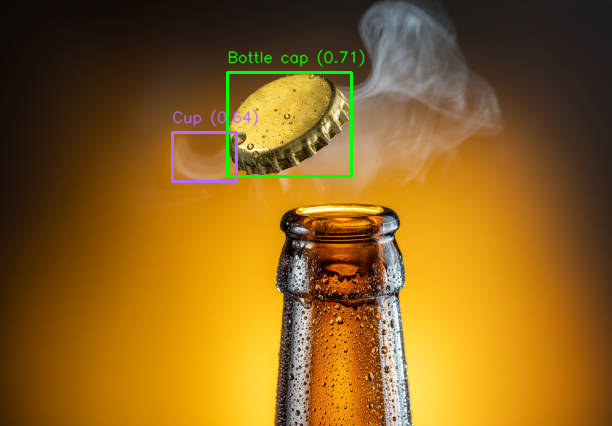

In [ ]:
from google.colab.patches import cv2_imshow

# Make predictions on a new image
image_path = '/content/drive/My Drive/Waste Detection and Classification/Output Images/test_image_3.jpg'
results = model(image_path)

# Get the predictions from the results object
boxes = results[0].boxes  # Bounding boxes information
confidences = boxes.conf  # Confidence scores for each detection
class_ids = boxes.cls  # Class IDs for each detection

# Convert class IDs to integers for accessing class names
class_ids = class_ids.int()  # Convert tensor to integer

# Load the class names from the model
class_names = model.names  # Access the class names from the model

# Define a color map for different object categories (you can customize these colors)
color_map = {
    "Aluminium foil": (255, 0, 0),  # Red
    "Bottle cap": (0, 255, 0),  # Green
    "Bottle": (0, 0, 255),  # Blue
    "Broken glass": (255, 165, 0),  # Orange
    "Can": (255, 255, 0),  # Yellow
    "Carton": (0, 255, 255),  # Cyan
    "Cigarette": (128, 0, 128),  # Purple
    "Cup": (255, 105, 180),  # Hot Pink
    "Lid": (255, 69, 0),  # Red-Orange
    "Other litter": (128, 128, 128),  # Gray
    "Other plastic": (0, 255, 0),  # Green
    "Paper": (0, 128, 0),  # Dark Green
    "Plastic bag - wrapper": (255, 182, 193),  # Light Pink
    "Plastic container": (186, 85, 211),  # Medium Orchid
    "Pop tab": (255, 140, 0),  # Dark Orange
    "Straw": (72, 61, 139),  # Dark Slate Blue
    "Styrofoam piece": (0, 255, 255),  # Cyan
    "Unlabeled litter": (169, 169, 169),  # Dark Gray
}

# Open the image using OpenCV
image = cv2.imread(image_path)

# Iterate over each prediction and draw the bounding box with label and color
for i, box in enumerate(boxes.xyxy):  # Accessing bounding box coordinates (xyxy format)
    # Extract the box coordinates and convert to integer
    x1, y1, x2, y2 = box.tolist()  # Convert tensor to list and extract coordinates
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])  # Convert coordinates to integers

    label = class_names[int(class_ids[i])]  # Get the label name
    confidence = confidences[i].item()  # Confidence score

    # Set the color based on the object label (use a default if label is unknown)
    color = color_map.get(label, (255, 255, 255))  # Default to white if not in color_map

    # Draw the bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

    # Prepare the label text: label + confidence score
    label_text = f"{label} ({confidence:.2f})"

    # Get text size to adjust placement of the text
    font_scale = 0.5
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_size = cv2.getTextSize(label_text, font, font_scale, 1)[0]
    text_x = x1
    text_y = y1 - 10 if y1 - 10 > 10 else y1 + text_size[1]  # Adjust if label is too close to the top

    # Draw the label text
    cv2.putText(image, label_text, (text_x, text_y), font, font_scale, color, 1, cv2.LINE_AA)


# Save or display the image with bounding boxes and labels
output_path = '/content/drive/My Drive/Waste Detection and Classification/Output Images/output_image_1.jpg'
cv2.imwrite(output_path, image)  # Save the output image

# Display the image with bounding boxes and labels (optional)
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()